In [ ]:
import sys
import os
build_path = os.path.join(os.getcwd(), "..", "build")
!cmake -B {build_path} -DPYTHON_EXECUTABLE={sys.executable} -Wno-dev -DCMAKE_BUILD_TYPE=Release ..
!cmake --build {build_path}

In [2]:
os.chdir(build_path)
import pypumila
# to reload pypumila, restart python kernel.
# importlib.reload(pypumila) <- does not work

import numpy as np
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

In [3]:
def learn(hidden, gamma, it = 100000, model = None):
    print(f"hidden = {int(hidden)}")
    print(f"gamma = {gamma}")
    if model is None:
        model = pypumila.Pumila12.make_shared(int(hidden), gamma)
    op_models = [
        lambda: pypumila.Pumila3.make_shared(""),
        lambda: pypumila.Pumila8s.make_shared("pumila8s_3162"),
        lambda: pypumila.Pumila11.make_shared("pumila11_300_0.9_100000"),
    ]
    reward = []
    score = []
    # ih = []
    sim = pypumila.GameSim()
    rnd_p = random.random()
    op_model = random.choice(op_models)()
    op_sim = pypumila.GameSim(op_model)
    sim.set_opponent_sim(op_sim)
    with tqdm(total=it) as pbar:
        while pbar.n < it:
            # for e in range(max_step):
            pbar.update()
            field_before = sim.field2_copy()
            op_field_before = op_sim.field2_copy()
            a = model.get_action_rnd(field_before, op_field_before, rnd_p)
            sim.put(pypumila.actions[a])
            op_sim.step()
            while not sim.is_free_phase():
                sim.step()
                op_sim.step()
            field_after = sim.field2_copy()
            op_field_after = op_sim.field2_copy()
            model.learn_step(field_before, a, op_field_before, field_after, op_field_after)
            reward.append(model.calc_reward(field_after, op_field_after))
            score.append(field_after.total_score())
            if sim.is_over:
                sim = pypumila.GameSim()
                rnd_p = random.random()
                sim.set_opponent_sim(op_sim)
            if op_sim.is_over:
                op_sim.stop_action()
                op_model = random.choice(op_models)()
                op_sim = pypumila.GameSim(op_model)
                sim.set_opponent_sim(op_sim)
    model.save_file(f"pumila12_{hidden}_{gamma}_{it}")
    return [model, reward, score]

In [4]:
models = []
rewards = []
scores = []
for gamma in [0.9]:
    model, reward, score = learn(300, gamma, 2000000)
    models.append(model)
    rewards.append(reward)
    scores.append(score)

hidden = 300
gamma = 0.9


  0%|          | 0/2000000 [00:00<?, ?it/s]

In [31]:
for i, gamma in enumerate([0.5, 0.75, 0.9, 0.99]):
    model, reward, score = learn(300, gamma, 100000, 100, models[i])
    models[i] = model
    rewards[i] += reward
    scores[i] += score

hidden = 300
gamma = 0.5


  0%|          | 0/100000 [00:00<?, ?it/s]

hidden = 300
gamma = 0.75


  0%|          | 0/100000 [00:00<?, ?it/s]

hidden = 300
gamma = 0.9


  0%|          | 0/100000 [00:00<?, ?it/s]

hidden = 300
gamma = 0.99


  0%|          | 0/100000 [00:00<?, ?it/s]

In [32]:
[len(m.diff_history) for m in models]

[2425258, 2420000, 2420000, 2420000]

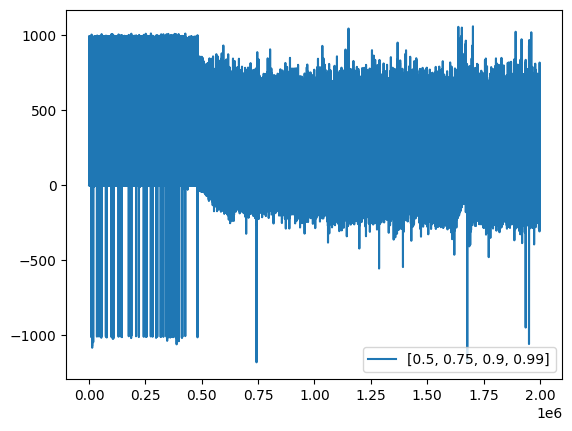

In [5]:
l = min(len(m.diff_history) for m in models)
plt.plot(np.array([m.diff_history[:l] for m in models]).T, label=[0.5, 0.75, 0.9, 0.99])
plt.legend()

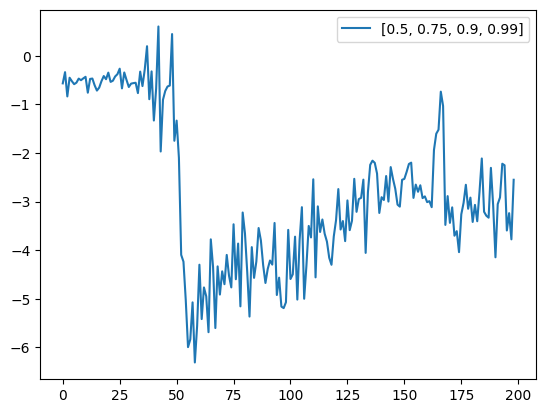

In [6]:
ar = np.array([m.diff_history[:l] for m in models])
plt.plot(np.array([[np.average(ar[j, i:i+10000]) for i in range(0, l-10000, 10000)] for j in range(len(models))]).T, label=[0.5, 0.75, 0.9, 0.99])
plt.legend()

In [7]:
# plt.plot(np.array(rewards).T, label=[0.5, 0.75, 0.9, 0.99])
# plt.legend()

In [8]:
# ar = np.array(rewards)
# plt.plot(
#     np.array([[np.average(ar[j, i:i+1000]) for i in range(len(rewards[j])-1000)] for j in range(len(rewards))]).T,
#     label=[0.5, 0.75, 0.9, 0.99]
# )
# plt.legend()

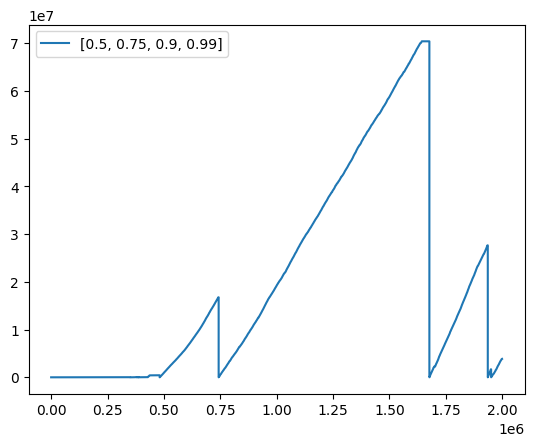

In [9]:
plt.plot(np.array(scores).T, label=[0.5, 0.75, 0.9, 0.99])
plt.legend()

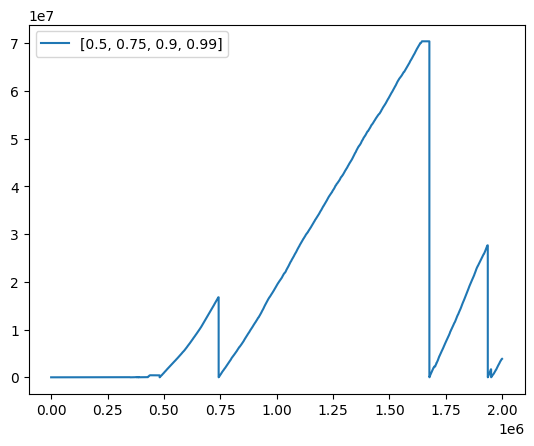

In [10]:
ar = np.array(scores)
plt.plot(
    np.array([[np.average(ar[j, i:i+50]) for i in range(0, len(scores[j])-50, 1)] for j in range(len(scores))]).T,
    label=[0.5, 0.75, 0.9, 0.99]
)
plt.legend()

In [17]:
sim = pypumila.GameSim()
op_sim = pypumila.GameSim(pypumila.Pumila8s.make_shared("pumila8s_3162"))
sim.set_opponent_sim(op_sim)
win = pypumila.Window([sim, op_sim])
model = models[0]
# model = pypumila.Pumila11.make_shared(1, 1)
# model.load_file("pumila11_300_0.5_10000")

In [ ]:
prev_r = [0, 0, 0]
# con = []
while True:
    while not sim.is_free_phase():
        win.step(True)
        # if sim.current_chain and sim.current_chain.connections != con:
        #     print(sim.current_chain.connections)
        #     con = sim.current_chain.connections
    f = sim.field2_copy()
    op_f = op_sim.field2_copy()
    r = [f.current_step().chain_num(), f.current_step().chain_score(), f.prev_puyo_num(), model.calc_reward(f, op_f)]
    if prev_r != r:
        prev_r = r
        print(r)
    a = model.get_action(sim)
    print(model.action_coeff())
    sim.soft_put(pypumila.actions[a])
    while sim.is_free_phase():
        win.step(True)

In [ ]:
model.get_in_nodes(f).in_nodes[:, -20:]

In [19]:
win.quit()